# Clustering FakeNewsNet - PolitiFact content

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

In [57]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

In [58]:
from itertools import product
from collections import defaultdict


# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

In [59]:
# Set path to data folder
DATA_DIR = Path(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data")

## Load data

In [60]:
dataset = 'BuzzFeed'

In [61]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}News.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}User.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}NewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(22779, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,45,1,1,BuzzFeed_Real_45,98d2b98ce305174e2f6c10b8f8a1a9d5
1,127,2,1,BuzzFeed_Fake_36,a273d0fd07c18a884ce2aa425813eb06
2,115,3,1,BuzzFeed_Fake_24,ac091e92df9e854a07563ffb397925d4
3,180,3,1,BuzzFeed_Fake_89,ac091e92df9e854a07563ffb397925d4
4,140,4,1,BuzzFeed_Fake_49,d2ded2de054f2ceb43dff7f80fc46774


In [62]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_real_news_content.csv', engine="pyarrow")
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)
df['news_id']   = newsId
df.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}NewsContent.csv', index=False)

df.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_id
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",BuzzFeed_Real_1
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",BuzzFeed_Real_2
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",BuzzFeed_Real_3
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",BuzzFeed_Real_4
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",BuzzFeed_Real_5


In [71]:
df[df['news_id'].apply(lambda x: x in [f'{dataset}_Real_91', f'{dataset}_Fake_91'])]

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_id
90,Real_91-Webpage,Is Donald Trump qualified to be president?,Off Message Is Donald Trump qualified to be pr...,http://politi.co/2dkiM5e,http://v.politico.com/images/1155968404/201609...,"Jack Shafer,Kyle Cheney,Daniel Strauss,Daniel ...",http://politi.co,{'$date': 1474866599000},NaN,http://v.politico.com/images/1155968404/201609...,http://www.politico.com/story/2016/09/is-donal...,"{""description"": ""In the most pivotal moment of...",BuzzFeed_Real_91
181,Fake_91-Webpage,People Noticed Something Odd About Hillary’s O...,People Noticed Something Odd About Hillary’s O...,http://rightwingnews.com/top-news/people-notic...,http://rightwingnews.com/wp-content/uploads/20...,Lisa Smith,http://rightwingnews.com,{'$date': 1475010040000},NaN,http://0.gravatar.com/avatar/3728144c20aefded7...,http://rightwingnews.com/top-news/people-notic...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",BuzzFeed_Fake_91


In [73]:
np.random.seed(0)

# Determine test split size
test_size   = 0.2
newsIds     = list(newsId[0].unique())
N_total     = len(newsIds)
N_test      = int(test_size * N_total)

# Shuffle newsIds
newsIds     = np.random.permutation(newsIds)

# Split news into train and test
testIds     = newsIds[:N_test]
trainIds    = newsIds[N_test:]

assert np.intersect1d(testIds, trainIds).__len__() == 0

# Store test and train ids
with open(DATA_DIR / f'processed/FakeNewsNet/{dataset}_testIds.txt', 'w') as f:
    f.write('\n'.join(testIds))
with open(DATA_DIR / f'processed/FakeNewsNet/{dataset}_trainIds.txt', 'w') as f:
    f.write('\n'.join(trainIds))

## Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [74]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].progress_apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

100%|██████████| 22779/22779 [00:00<00:00, 151288.55it/s]


In [75]:
# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 3002/3002 [00:03<00:00, 771.86it/s]


In [76]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)
train_weighted_edgelist     = weighted_edgelist.query('source not in @testIds or target not in @testIds')

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv', index=False)
train_weighted_edgelist.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv', index=False)

# Create networkx graph
G = nx.from_pandas_edgelist(train_weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)


Is the graph fully connected: True

Number of nodes: 	182
Number of edges: 	4591
Network diameter: 	4
Average shortest path: 	1.7853


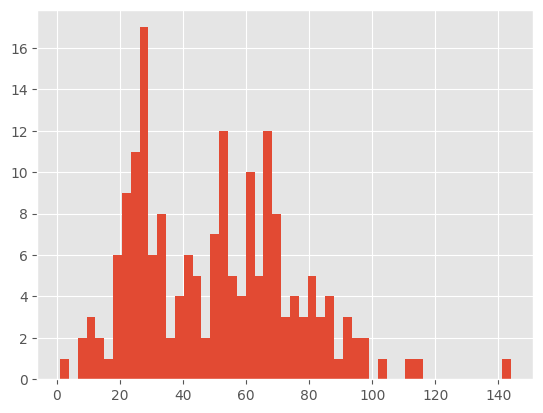

In [77]:
# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

In [27]:
# Other statistics
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)
density                 = nx.density(G)

## Visualize the FakeNewsNet PolitiFact graph

100%|██████████| 2/2 [00:00<?, ?it/s]


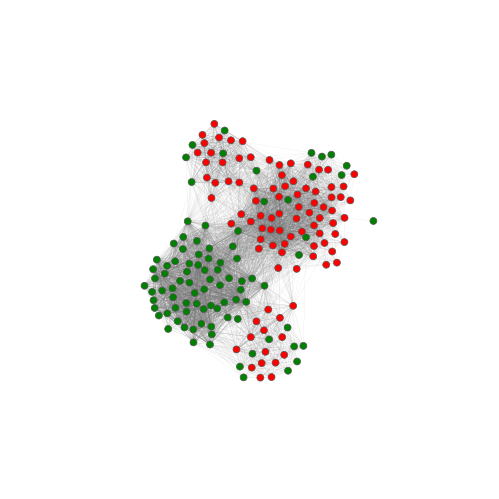

In [78]:
# Create ground truth partition
colors = ['green', 'red']
fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(fakenews_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

### Clustering - Louvain method

In [79]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.5488326172468484


100%|██████████| 5/5 [00:00<00:00, 4708.47it/s]


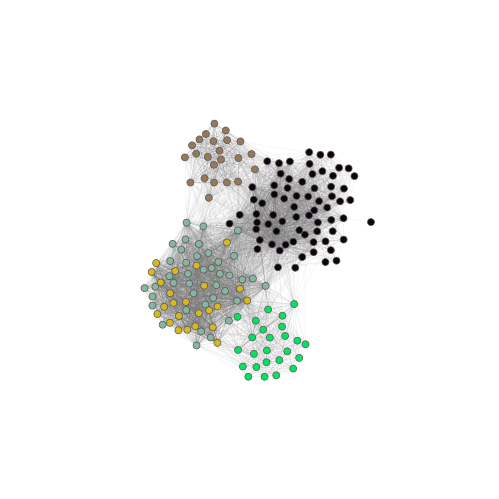

In [80]:
colors = [f"C{i}" for i in range(louvain_partition.__len__())]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(louvain_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

## Node2Vec

In [81]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

# Set path to data folder
DATA_DIR = Path(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data")

In [82]:
dataset = 'BuzzFeed'

In [83]:
with open(DATA_DIR / f'processed/FakeNewsNet/{dataset}_testIds.txt', 'r') as f:
    testIds = f.read().split('\n')

with open(DATA_DIR / f'processed/FakeNewsNet/{dataset}_trainIds.txt', 'r') as f:
    trainIds = f.read().split('\n')
    
full_weighted_edgelist = pd.read_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv')

# Create networkx graph
G = nx.from_pandas_edgelist(full_weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)

## Node2Vec

https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef

In [84]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from node2vec import Node2Vec

np.random.seed(42)

# Generate walks
node2vec    = Node2Vec(G, dimensions=32, walk_length=10, num_walks=100)
model       = node2vec.fit(window=10, min_count=1)

# Get vector representations
train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in trainIds}
test2vec        = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in testIds}

Xtrain, Xtest   = np.array(list(train2vec.values())), np.array(list(test2vec.values()))
ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in trainIds]) 
ytest           = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in testIds])

ytrain          = (ytrain == 'real').astype(int)
ytest           = (ytest == 'real').astype(int)

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 73.05it/s]


### Examine global vs. local modeling

In [85]:
from sklearn.cluster import KMeans

np.random.seed(0)

K = 4

cls             = KMeans(n_clusters=K, random_state=0, n_init=100)
kmeans_train    = cls.fit_predict(Xtrain)
kmeans_test     = cls.predict(Xtest)

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Fit global classifier
np.random.seed(0)
clf_global          = RandomForestClassifier(n_estimators=100, random_state=42)
clf_global.fit(Xtrain, ytrain)

# Fit cluster classifiers
clf_local = {}
for k in tqdm(range(K)):
    np.random.seed(0)
    clf_cluster_    = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_cluster_.fit(Xtrain[kmeans_train == k], ytrain[kmeans_train == k])
    clf_local[k]    = clf_cluster_ 

100%|██████████| 4/4 [00:00<00:00,  9.47it/s]


In [87]:
global_preds    = clf_global.predict(Xtest)
print(f"Accuracy for global classifier: {np.mean(global_preds == ytest):.4f}")

local_preds = np.ones(ytest.shape) * -1
for k in range(K):
    if (kmeans_test == k).sum() != 0:
        pred_cluster_   = clf_local[k].predict(Xtest[kmeans_test == k])
        local_preds[kmeans_test == k] = pred_cluster_
        print(f"Accuracy for cluster {k}: {np.mean(pred_cluster_ == ytest[kmeans_test == k]):.4f}")

print(f"Accuracy for local classifier: {np.mean(local_preds == ytest):.4f}")

Accuracy for global classifier: 0.9444
Accuracy for cluster 0: 0.9231
Accuracy for cluster 1: 0.6000
Accuracy for cluster 2: 1.0000
Accuracy for cluster 3: 0.6667
Accuracy for local classifier: 0.8889


In [88]:
from collections import Counter

# Get baseline as majority voter
uniques, counts = np.unique(ytrain, return_counts=True)
majority_voter  = uniques[np.argmax(counts)]
baseline_preds  = majority_voter * np.ones(ytest.shape)

In [89]:
# add silhoutte score, davies bouldin index, within-cluster sum of squares, modularity, rand index, adjusted rand index, normalized mutual information, weighted f1 score, precision, recall, accuracy, confusion matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, f1_score, precision_score, recall_score, confusion_matrix

results = {}
for type_, ypred in [('baseline', baseline_preds), ('global', global_preds), ('local', local_preds), ('kmeans', kmeans_test)]:
    results[type_] = {}

    results[type_]['SS']               = silhouette_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['DBI']          = davies_bouldin_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['CHS']       = calinski_harabasz_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['ARI']           = adjusted_rand_score(ytest, ypred)
    results[type_]['NMI'] = normalized_mutual_info_score(ytest, ypred)
    results[type_]['accuracy']                      = np.mean(ytest == ypred)
    results[type_]['weighted_f1_score']             = f1_score(ytest, ypred, average='weighted')
    results[type_]['precision']                     = precision_score(ytest, ypred, average='weighted', zero_division=0.0)
    results[type_]['recall']                        = recall_score(ytest, ypred, average='weighted', zero_division=1.0)

results     = pd.DataFrame(results)

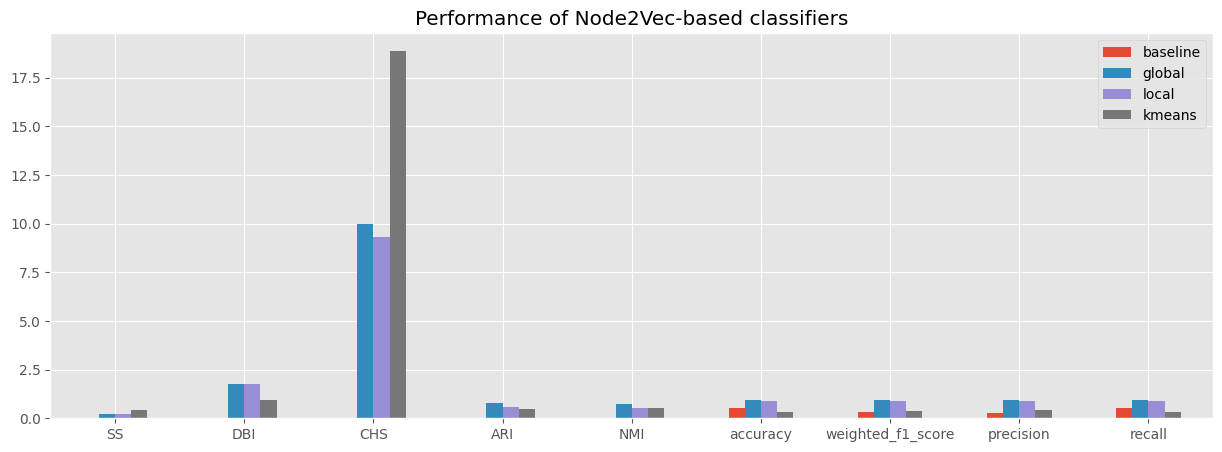

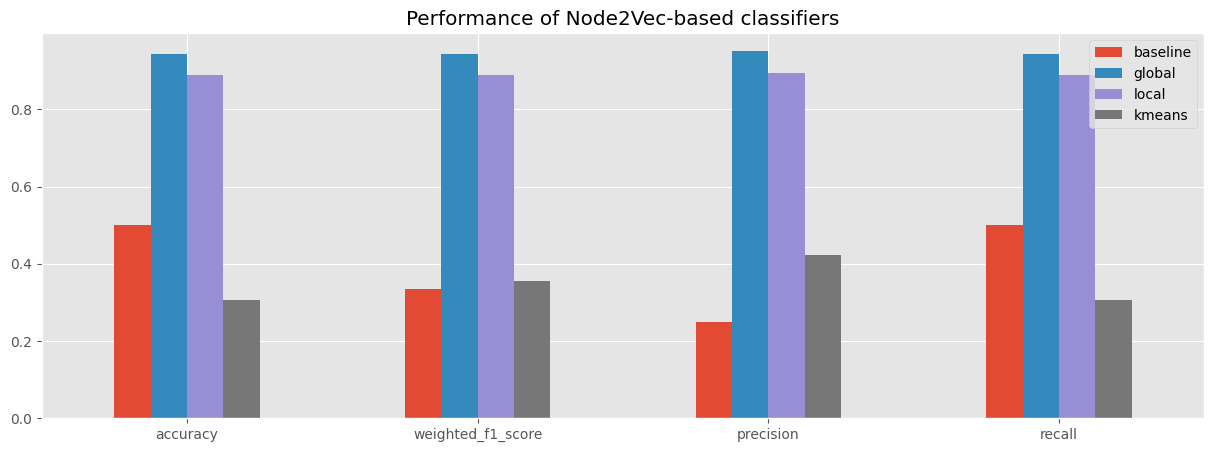

In [90]:
results.plot(kind='bar', figsize=(15, 5), rot=0, title='Performance of Node2Vec-based classifiers')
plt.legend(loc='upper right')
plt.show()

results.T[['accuracy', 'weighted_f1_score', 'precision', 'recall']].T.plot(kind='bar', figsize=(15, 5), rot=0, title='Performance of Node2Vec-based classifiers', legend=True)
plt.legend(loc='upper right')
plt.show()

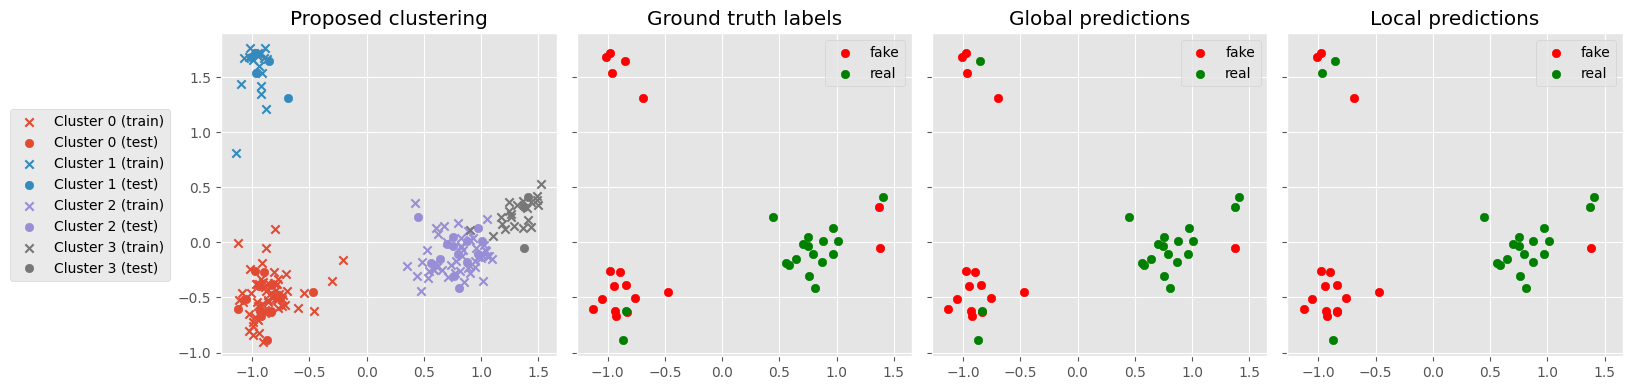

In [91]:
# Run PCA projection
pca             = PCA(n_components=2, random_state=42)
pca_proj        = pca.fit_transform(Xtrain)
pca_proj_test   = pca.transform(Xtest)

# Do a visualization with scatter plot from PCA that is colored by the cluster labels
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True, sharex=True, squeeze=False)
for k in range(K):
    axs[0, 0].scatter(pca_proj[kmeans_train == k, 0], pca_proj[kmeans_train == k, 1], color=f'C{k}', label=f'Cluster {k} (train)', marker='x')
    axs[0, 0].scatter(pca_proj_test[kmeans_test == k, 0], pca_proj_test[kmeans_test == k, 1], color=f'C{k}', label=f'Cluster {k} (test)', marker='o')

axs[0, 0].set_title('Proposed clustering')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(-0.65, 0.5))

for label in [0, 1]: # [fake, real]
    axs[0, 1].scatter(pca_proj_test[ytest == label, 0], pca_proj_test[ytest == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')
    axs[0, 2].scatter(pca_proj_test[global_preds == label, 0], pca_proj_test[global_preds == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')
    axs[0, 3].scatter(pca_proj_test[local_preds == label, 0], pca_proj_test[local_preds == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')

axs[0, 1].set_title('Ground truth labels')
axs[0, 2].set_title('Global predictions')
axs[0, 3].set_title('Local predictions')

axs[0, 1].legend(loc='upper right')
axs[0, 2].legend(loc='upper right')
axs[0, 3].legend(loc='upper right')

axs[0, 3].legend()
plt.tight_layout()
plt.show()


## Spectral Clustering


### Classifying based on "eigenfeatures"

In [39]:
from sklearn.cluster import SpectralClustering

In [40]:
L = nx.laplacian_matrix(G).toarray()

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [41]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [42]:
# Sort the eigenvalues and eigenvectors in ascending order
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

In [43]:
# Choose the number of clusters
n_clusters = 2

# Use the first n eigenvectors to cluster the nodes
X = eigenvectors[:,:n_clusters]
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')
spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', n_clusters=2)

In [44]:
print(spectral.labels_)

[1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0
 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0
 1 1 0 1 1 0 1 1 1 0 1 1 1]


In [46]:
news = pd.read_csv(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data\processed\FakeNewsNet\PolitiFactNewsContent.csv")